In [16]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# 总结：

    1、下面给出一个比较全的过程，包括：
        1.1 数据的处理和清洗，去除无用的数据。
        1.2 每小时的数据预测下一个小时的数据。
        1.3 建模，预测。
     
    2、其实看下来，总体并不像一个基于时间序列的预测模型，因为：
        2.1 每一次预测都是基于当前时间的特征。（可以理解为seq中每个word的vector比较长）
        2.2 seq长度是1（就是预测仅依赖当前时间步）
        2.3 所以总体来看，用一个Dense效果也是一样的（谁让你seq长度是1啊…）
        

# 数据处理

In [2]:
def parse(x):
    return datetime.strptime(x,'%Y %m %d %H')

In [16]:
dataset=pd.read_csv('./data/raw.csv',
                    parse_dates = [['year', 'month', 'day', 'hour']], 
                    index_col=0, date_parser=parse)
dataset.drop('No',axis=1,inplace=True)

In [17]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [18]:
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('./data/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


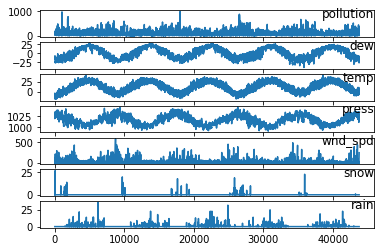

In [19]:
'''
绘图查看
'''
dataset=pd.read_csv('./data/pollution.csv',header=0,index_col=0)
values=dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [20]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


# 准备训练数据

In [2]:
# convert series to supervised learning
'''
将series数据转化成监督学习任务
大概就是把所有的series往前移了1个位置，shift，shift操作啦
'''
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
#     print(df.head())
    
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# reframed = series_to_supervised(scaled, 1, 1)
# reframed.head()

In [3]:
'''
加载数据
'''
dataset=read_csv('./data/pollution.csv',header=0,index_col=0)
values=dataset.values

'''
将category的数据转换成数字，方便后续处理
当然也可以one-hot…
'''
encoder=LabelEncoder()
values[:,4]=encoder.fit_transform(values[:,4])

'''
处理数据格式
'''
values=values.astype('float32')

In [4]:
'''
数据归一化
'''
scaler=MinMaxScaler(feature_range=(0,1))
scaled=scaler.fit_transform(values)


In [5]:
'''
拿到每个series的label值
'''
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
'''
看下来t-1时刻的var1~8作为预测输入，t时刻的var1作为预测输出即可
'''
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [13]:
'''
分割训练集和测试集
'''
def get_train_test():
    # 用一年的数据训练
    values=reframed.values
    n_train_hours=365*24

    train=values[:n_train_hours,:]
    test=values[n_train_hours:,:]

    # 分割训练和测试集
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    '''
    因为keras的LSTM接收的输入是（example_nums,seq_len,word_vec）
    '''
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    return [train_X,train_y,test_X,test_y]

useful_data=get_train_test()

train_X=useful_data[0]
train_y=useful_data[1]
test_X=useful_data[2]
test_y=useful_data[3]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


# 构建模型


In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [8]:
# 训练
# fit network
history = model.fit(train_X, train_y, epochs=50, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0548 - val_loss: 0.0445
Epoch 2/50
 - 0s - loss: 0.0341 - val_loss: 0.0430
Epoch 3/50
 - 0s - loss: 0.0187 - val_loss: 0.0408
Epoch 4/50
 - 0s - loss: 0.0158 - val_loss: 0.0278
Epoch 5/50
 - 1s - loss: 0.0151 - val_loss: 0.0201
Epoch 6/50
 - 0s - loss: 0.0150 - val_loss: 0.0184
Epoch 7/50
 - 1s - loss: 0.0148 - val_loss: 0.0173
Epoch 8/50
 - 0s - loss: 0.0147 - val_loss: 0.0163
Epoch 9/50
 - 0s - loss: 0.0147 - val_loss: 0.0150
Epoch 10/50
 - 0s - loss: 0.0146 - val_loss: 0.0149
Epoch 11/50
 - 0s - loss: 0.0148 - val_loss: 0.0149
Epoch 12/50
 - 0s - loss: 0.0146 - val_loss: 0.0146
Epoch 13/50
 - 0s - loss: 0.0146 - val_loss: 0.0141
Epoch 14/50
 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 15/50
 - 0s - loss: 0.0145 - val_loss: 0.0139
Epoch 16/50
 - 0s - loss: 0.0145 - val_loss: 0.0137
Epoch 17/50
 - 0s - loss: 0.0145 - val_loss: 0.0141
Epoch 18/50
 - 0s - loss: 0.0145 - val_loss: 0.0137
Epoch 19/50
 - 0s - loss

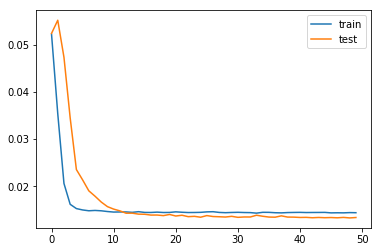

In [66]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

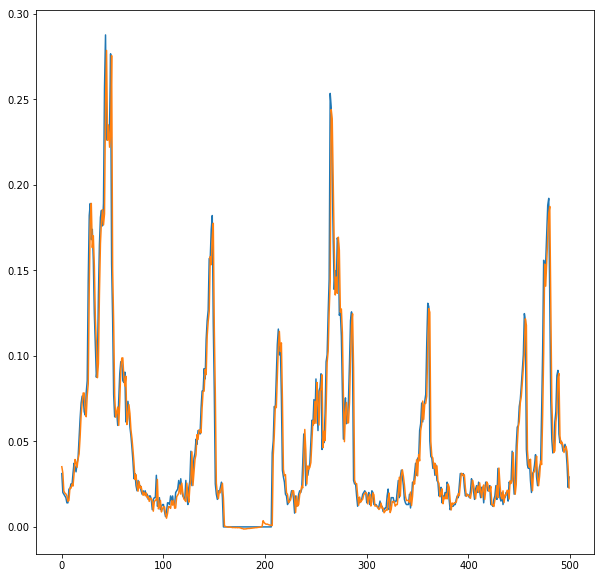

In [24]:
'''
测试
'''
def pred_way1():
    useful_data=get_train_test()

    train_X=useful_data[0]
    train_y=useful_data[1]
    test_X=useful_data[2]
    test_y=useful_data[3]

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    yhat_plot=np.reshape(yhat,(len(yhat),1))
    plt.figure(figsize=(10,10))
    plt.plot(test_y[:500])
    plt.plot(yhat_plot[:500])
pred_way1()

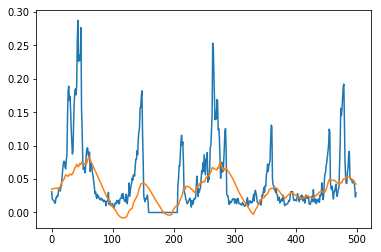

In [38]:
def pred_way2():
    useful_data=get_train_test()

    train_X=useful_data[0]
    train_y=useful_data[1]
    test_X=useful_data[2]
    test_y=useful_data[3]

    # make a prediction
    yhat = model.predict(test_X)
    
    # 
    last_pred=None
    all_pred=[]
    for i in range(test_X.shape[0])[:500]:
        temp_in=test_X[i,:]
        if i==0:
            temp_in=np.reshape(temp_in,(1,temp_in.shape[0],temp_in.shape[1]))
        else:
            temp_in[0,0]=last_pred[0][0]
            temp_in=np.reshape(temp_in,(1,temp_in.shape[0],temp_in.shape[1]))

#         print(temp_in,last_pred)
        last_pred=model.predict(temp_in)
        all_pred.append(last_pred[0][0])
    
    plt.plot(test_y[:500])
    plt.plot(all_pred)
        
    
#     test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

#     yhat_plot=np.reshape(yhat,(len(yhat),1))
#     plt.figure(figsize=(10,10))
#     plt.plot(test_y[:500])
#     plt.plot(yhat_plot[:500])
pred_way2()

In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)